In [93]:
#Importing general packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Image packages
import PIL
import PIL.Image

#Model packages
import tensorflow as tf
from tensorflow.keras import layers

#File saving packages
import pathlib
import os
import warnings
warnings.filterwarnings('ignore')

In [94]:
#Reading train csv (index col = 0 as need to copy images into train folder)
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(20453, 2)


image   labels
0  Train_0.jpg     scab
1  Train_1.jpg  complex
2  Train_2.jpg  healthy
3  Train_3.jpg     rust
4  Train_4.jpg  healthy

# Data Analysis

In [95]:
import random 
base_path = 'train_images/'
plt.figure(figsize=(18,6))

for i in range(4):
    plt.subplot(1, 4, i+1)
    idx = random.randint(0, len(df)-1)
    img_path = os.path.join(base_path, df.iloc[idx]['image'])
    img = plt.imread(img_path)
    
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(df.iloc[idx]['labels'])
    
plt.show()

Let's run some bar plot to see the distribution for each class of the disease.

In [96]:
labels = df['labels'].unique()
freqs = [ (df['labels'] == label).sum() for label in labels ]

plt.figure(figsize=(16,4))
plt.barh(range(len(labels)), freqs)
plt.yticks(range(len(labels)), labels)

plt.show()

From the figure above, we can see that some labels are too few, e.g., "rust complex" or "powdery_mildew complex". Trying to predict them is difficult because there is not much data to train our model. If we observe closely, these labels are, in fact, a combinations of other diseases. "rust complex" = "rust" and "complex" together. 

Due to their low frequencies, we group them into another category, called **multiple_diseases**.

In [97]:
selected_labels = ['healthy', 'complex', 'frog_eye_leaf_spot', 'powdery_mildew', 'rust', 'scab']
df['labels'] = df['labels'].map(lambda x: x if x in selected_labels else 'multiple_diseases')

In [98]:
labels = df['labels'].unique()
freqs = [ (df['labels'] == label).sum() for label in labels ]

plt.figure(figsize=(16, 3))
plt.barh(range(len(labels)), freqs)
plt.yticks(range(len(labels)), labels)

plt.show()

In [99]:
one_hot_features = pd.get_dummies(df['labels'])
df = pd.concat((df, one_hot_features), axis=1)
df = df.drop(['labels'], axis=1)

In [100]:
df = df.set_index('image')

In [101]:
import shutil
from shutil import copyfile

#if temp folder exists, delete the temp folder
if os.path.exists('temp'):
    shutil.rmtree('temp')

#create a folder named temp and subfolders
os.mkdir('temp')
os.mkdir('temp/images')
os.mkdir('temp/images/healthy')
os.mkdir('temp/images/multiple_diseases')
os.mkdir('temp/images/rust')
os.mkdir('temp/images/scab')
os.mkdir('temp/images/complex')
os.mkdir('temp/images/frog_eye_leaf_spot')
os.mkdir('temp/images/powdery_mildew')

In [102]:
#image file source
imagesSorce = 'train_images'

#split into folders of different classes (in temp)
split = 'temp/images/'

# copy images to train folder
for index, data in df.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(imagesSorce, index)
    destination = os.path.join(split, label, index)
    copyfile(filepath, destination)
    

In [103]:
#print how many types of images of each class there are
for subdir in os.listdir(split):
    print(subdir, len(os.listdir(os.path.join(split, subdir))))

complex 1693
frog_eye_leaf_spot 3181
healthy 5140
multiple_diseases 1355
powdery_mildew 1184
rust 2482
scab 5418


In [104]:
#define parameters
batch_size = 32
img_height = 180
img_width = 180

In [105]:
#create training data (train-0.8 test-0.2)
train_ds = tf.keras.utils.image_dataset_from_directory(
    'temp/images',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 20453 files belonging to 7 classes.
Using 16363 files for training.


In [106]:
#create validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    'temp/images',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 20453 files belonging to 7 classes.
Using 4090 files for validation.


In [107]:
val_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None, 7)), types: (tf.float32, tf.float32)>

In [108]:
#Printing 
class_names = train_ds.class_names
num_classes = len(class_names)
print("Number of classes are: ",num_classes)
print("Classes are: ", class_names)

Number of classes are:  7
Classes are:  ['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']


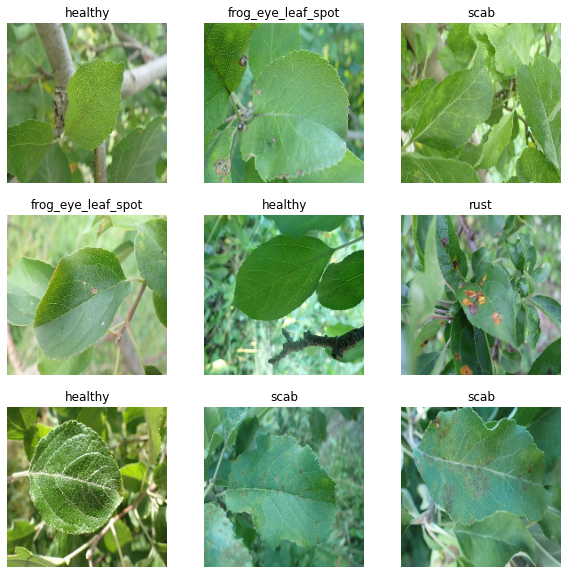

In [109]:
#Visualize data (before image augmentation)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

In [110]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32, 7)


In [111]:
#autotune the entire process to your hardware/experiment design, makes training significantly faster.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [120]:
#Image augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.5),
    # layers.RandomTranslation( width_factor=0.2, height_factor=0.2)
  ]
)

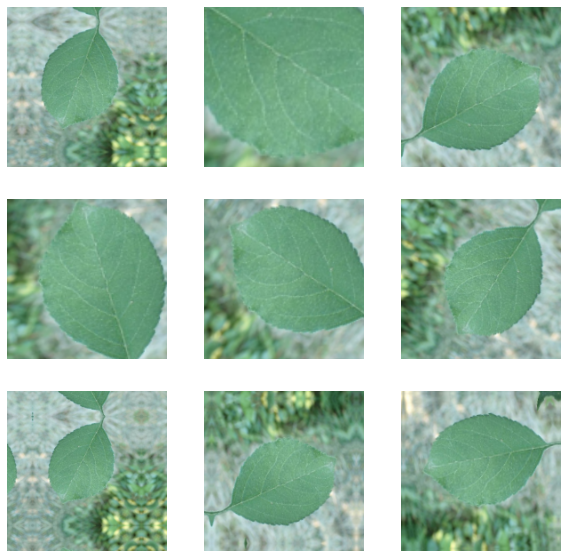

In [121]:
#Display images after augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [122]:
#Build model
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, (3, 3), padding="same",input_shape=(180,180,3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(3, 3)),
  layers.Dropout(0.25),
  layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(1024,activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

In [123]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
                    
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=1e-3, decay=1e-3 / 100)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [124]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_36 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 60, 64)      

In [125]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint],
    verbose=1
)

Epoch 1/100
512/512 [==============================] - 30s 55ms/step - loss: 1.9631 - accuracy: 0.3278 - val_loss: 2.0220 - val_accuracy: 0.3103

Epoch 00001: val_loss improved from inf to 2.02200, saving model to best.h5
Epoch 2/100
512/512 [==============================] - 28s 54ms/step - loss: 1.5578 - accuracy: 0.4265 - val_loss: 1.6845 - val_accuracy: 0.4210

Epoch 00002: val_loss improved from 2.02200 to 1.68450, saving model to best.h5
Epoch 3/100
512/512 [==============================] - 28s 54ms/step - loss: 1.2028 - accuracy: 0.5542 - val_loss: 1.1891 - val_accuracy: 0.5337

Epoch 00003: val_loss improved from 1.68450 to 1.18908, saving model to best.h5
Epoch 4/100
512/512 [==============================] - 28s 55ms/step - loss: 1.0417 - accuracy: 0.6154 - val_loss: 5.0108 - val_accuracy: 0.3120

Epoch 00004: val_loss did not improve from 1.18908
Epoch 5/100
512/512 [==============================] - 28s 54ms/step - loss: 0.9846 - accuracy: 0.6376 - val_loss: 0.9006 - val_a

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [127]:
from keras_preprocessing import image
filepath = 'test_images/Test_1729.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.12052815 0.11791811 0.12696134 0.1180477  0.11791812 0.2729286
  0.12569803]]


Some notes:

Must crop so that ur leave is the biggest part of the picture

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.12278995 0.11968401 0.13920079 0.11984929 0.11968188 0.13195331
  0.24684085]]


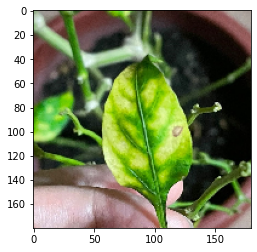

In [141]:
filepath = 'imagesForTesting/mummy1.jpeg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

In [129]:
filepath = 'imagesForTesting/mummy2.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.11702811 0.11693137 0.12541004 0.11723511 0.11948054 0.11815061
  0.28576422]]


['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.11640459 0.11628276 0.12260309 0.11631701 0.11629654 0.11834665
  0.29374936]]


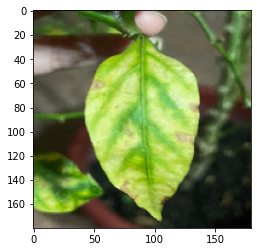

In [130]:
filepath = 'imagesForTesting/mummy2editted.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.12083583 0.11860445 0.11915047 0.11999165 0.11920302 0.26368672
  0.13852786]]


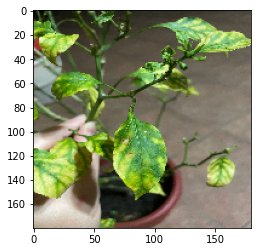

In [131]:
filepath = 'imagesForTesting/mummy3.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.12433635 0.12090845 0.12091289 0.12340883 0.12090646 0.18591341
  0.20361371]]


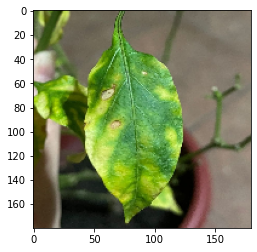

In [132]:
filepath = 'imagesForTesting/mummy3editted.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.12403102 0.1209839  0.12098131 0.12442084 0.1209771  0.1995298
  0.189076  ]]


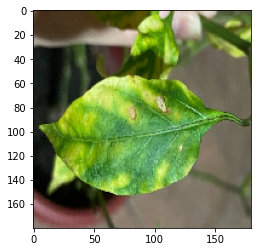

In [133]:
filepath = 'imagesForTesting/mummy3rotate.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.12058951 0.12059806 0.13267955 0.1207163  0.22842571 0.12273262
  0.15425833]]


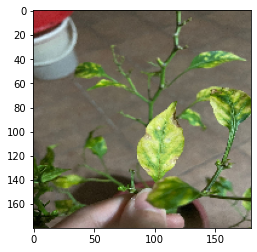

In [134]:
filepath = 'imagesForTesting/mummy4.jpeg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.12141683 0.121436   0.1550718  0.12149673 0.14810762 0.12187161
  0.21059933]]


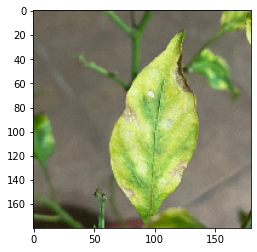

In [135]:
filepath = 'imagesForTesting/mummy4editted.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.11495469 0.11495345 0.11587406 0.11503497 0.30901068 0.11521129
  0.11496081]]


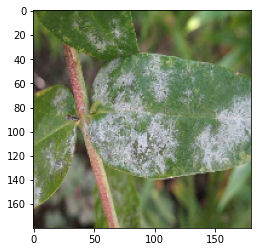

In [137]:
filepath = 'imagesForTesting/test.jpeg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['complex', 'frog_eye_leaf_spot', 'healthy', 'multiple_diseases', 'powdery_mildew', 'rust', 'scab']
[[0.14948523 0.11919969 0.11902122 0.12006988 0.11896747 0.11905719
  0.2541993 ]]


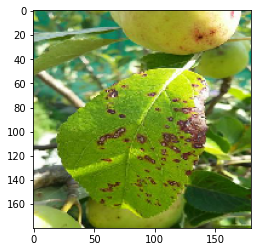

In [140]:
filepath = 'imagesForTesting/applescab.jpg'
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

In [139]:
# import time
 
# #save model
# ts = int(time.time())
# file_path = f"./img_classifier/{ts}/"
# model.save(filepath=file_path, save_format='tf')

INFO:tensorflow:Assets written to: ./img_classifier/1643641699/assets
